In [8]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import math
from matplotlib.colors import ListedColormap
import matplotlib.colors as mcolors
import rasterio
import pyvista as pv
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from sklearn.metrics import mean_squared_error
import os



In [9]:
def get_mass_momentum_diff(file_number, wind_direction_folder, wind_direction_file, plot=True):
    mass_angle_file = f"/Volumes/Expansion/wind_data/{file_number}/dems_folder/dem0/mass/grass/{wind_direction_folder}/{wind_direction_file}ang.asc"
    mass_vel_file = f"/Volumes/Expansion/wind_data/{file_number}/dems_folder/dem0/mass/grass/{wind_direction_folder}/{wind_direction_file}vel.asc"

    momentum_angle_file = f"/Volumes/Expansion/wind_data/{file_number}/dems_folder/dem0/momentum/grass/{wind_direction_folder}/{wind_direction_file}ang.asc"
    momentum_vel_file = f"/Volumes/Expansion/wind_data/{file_number}/dems_folder/dem0/momentum/grass/{wind_direction_folder}/{wind_direction_file}vel.asc"

    with rasterio.open(mass_angle_file) as ang_src_mass, rasterio.open(mass_vel_file) as vel_src_mass:
        angle_mass = ang_src_mass.read(1)  # Wind direction in degrees
        velocity_mass = vel_src_mass.read(1)  # Wind speed in m/s
        transform_mass = ang_src_mass.transform  # Georeferencing
        width_mass, height_mass = ang_src_mass.width, ang_src_mass.height  # Raster dimensions

    # Convert wind direction to U, V components for quiver plot
    angle_rad_mass = np.radians(angle_mass)  # Convert degrees to radians
    U_mass = velocity_mass * np.cos(angle_rad_mass)  # X component
    V_mass = velocity_mass * np.sin(angle_rad_mass)  # Y component

    # Downsample for visualization (adjust factor for performance)
    sample_factor = 5  # Change this to control arrow density
    X_mass, Y_mass = np.meshgrid(np.arange(0, width_mass, sample_factor), np.arange(0, height_mass, sample_factor))
    U_sampled_mass = U_mass[::sample_factor, ::sample_factor]
    V_sampled_mass = V_mass[::sample_factor, ::sample_factor]

    with rasterio.open(momentum_angle_file) as ang_src_momentum, rasterio.open(momentum_vel_file) as vel_src_momentum:
        angle_momentum = ang_src_momentum.read(1)  # Wind direction in degrees
        velocity_momentum = vel_src_momentum.read(1)  # Wind speed in m/s
        transform_momentum = ang_src_momentum.transform  # Georeferencing
        width_momentum, height_momentum = ang_src_momentum.width, ang_src_momentum.height  # Raster dimensions

    # Convert wind direction to U, V components for quiver plot
    angle_rad_momentum = np.radians(angle_momentum)  # Convert degrees to radians
    U_momentum = velocity_momentum * np.cos(angle_rad_momentum)  # X component
    V_momentum = velocity_momentum * np.sin(angle_rad_momentum)  # Y component

    # Downsample for visualization (adjust factor for performance)
    X_momentum, Y_momentum = np.meshgrid(np.arange(0, width_momentum, sample_factor), np.arange(0, height_momentum, sample_factor))
    U_sampled_momentum = U_momentum[::sample_factor, ::sample_factor]
    V_sampled_momentum = V_momentum[::sample_factor, ::sample_factor]

    # calculate the difference
    U_diff = U_sampled_momentum - U_sampled_mass
    V_diff = V_sampled_momentum - V_sampled_mass

    min_dimension = np.min([U_diff.shape[0], U_diff.shape[1]])
    U_diff = U_diff[:min_dimension, :min_dimension]
    V_diff = V_diff[:min_dimension, :min_dimension]

    X_diff = X_mass[:min_dimension, :min_dimension]
    Y_diff = Y_mass[:min_dimension, :min_dimension]

    # plot

    if plot:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax1 = fig.add_subplot(121)
        ax2 = fig.add_subplot(122)
        im1 = ax1.imshow(velocity_mass, cmap="coolwarm", origin="upper")  # Wind speed heatmap
        ax1.quiver(X_mass, Y_mass, U_sampled_mass, -V_sampled_mass, scale=300, color="black")  # Wind direction arrows

        ax1.set_title("Mass Solver")
        ax1.set_xlabel("X")
        ax1.set_ylabel("Y")

        im2 = ax2.imshow(velocity_momentum, cmap="coolwarm", origin="upper")  # Wind speed heatmap
        ax2.quiver(X_momentum, Y_momentum, U_sampled_momentum, -V_sampled_momentum, scale=300, color="black")  # Wind direction arrows

        ax2.set_title("Momentum Solver")
        ax2.set_xlabel("X")
        ax2.set_ylabel("Y")

        fig.tight_layout()
        plt.show()

        # plot the difference...
        fig = plt.figure(figsize=(10,8))
        
        plt.imshow(velocity_mass, cmap="coolwarm", origin="upper")
        plt.quiver(X_diff, Y_diff, U_diff, -V_diff, scale=300, color="black")
        plt.title("Difference")
        plt.xlabel('X')
        plt.ylabel("Y")
        plt.show()

    return U_diff, V_diff, min_dimension
    


In [10]:
def split_elevation(elevation, N, plot=True):
    rows, cols = elevation.shape


    if N >= rows or N >= cols:
        N = min(rows, cols) - 1

    block_size_x = rows // N
    block_size_y = cols // N
    new_elevation = np.zeros((N,N))

    for i in range(N):
        for j in range(N):
            block = elevation[i * block_size_x:(i + 1) * block_size_x, j * block_size_y:(j + 1) * block_size_y]
            
            new_elevation[i, j] = np.mean(block)
    
    if plot:
        figure = plt.figure(figsize=(10,12))
        
        ax1 = figure.add_subplot(121)
        ax1.imshow(elevation)
        ax1.set_title("Original Elevation")

        
        ax2 = figure.add_subplot(122)
        ax2.imshow(new_elevation)
        ax2.set_title(f"Approximated Elevation, N = {N}")
        plt.show()

    return new_elevation




In [11]:
def get_elevation_file(file_number, N):
    elevation_tif = f"/Volumes/Expansion/wind_data/{file_number}/dems_folder/dem0/dem0.tif"
    with rasterio.open(elevation_tif) as src:
        elevation = src.read(1)  # Reads all bands into a NumPy array
        elevation_npy = np.array(elevation)


    elevation_approx = split_elevation(elevation_npy, N, plot=False)
    return elevation_approx


In [12]:
def get_mass_grid(file_number, wind_direction_file, wind_direction_folder, N):
    mass_angle_file = f"/Volumes/Expansion/wind_data/{file_number}/dems_folder/dem0/mass/grass/{wind_direction_folder}/{wind_direction_file}ang.asc"
    mass_vel_file = f"/Volumes/Expansion/wind_data/{file_number}/dems_folder/dem0/mass/grass/{wind_direction_folder}/{wind_direction_file}vel.asc"
    
    with rasterio.open(mass_angle_file) as ang_src_mass, rasterio.open(mass_vel_file) as vel_src_mass:
        angle_mass = ang_src_mass.read(1)  # Wind direction in degrees
        velocity_mass = vel_src_mass.read(1)  # Wind speed in m/s
        transform_mass = ang_src_mass.transform  # Georeferencing
        width_mass, height_mass = ang_src_mass.width, ang_src_mass.height  # Raster dimensions

    # Convert wind direction to U, V components for quiver plot
    angle_rad_mass = np.radians(angle_mass)  # Convert degrees to radians
    U_mass = velocity_mass * np.cos(angle_rad_mass)  # X component
    V_mass = velocity_mass * np.sin(angle_rad_mass)  # Y component

    # Downsample for visualization (adjust factor for performance)
    sample_factor = 5  # Change this to control arrow density
    X_mass, Y_mass = np.meshgrid(np.arange(0, width_mass, sample_factor), np.arange(0, height_mass, sample_factor))
    U_sampled_mass = U_mass[::sample_factor, ::sample_factor]
    V_sampled_mass = V_mass[::sample_factor, ::sample_factor]

    U_sampled_mass = U_sampled_mass[:N, :N]
    V_sampled_mass = V_sampled_mass[:N, :N]

    return U_sampled_mass, V_sampled_mass

In [13]:
def should_use_num(file_number, wind_direction_file, wind_direction_folder):

    mass_angle_file = f"/Volumes/Expansion/wind_data/{file_number}/dems_folder/dem0/mass/grass/{wind_direction_folder}/{wind_direction_file}ang.asc"
    mass_vel_file = f"/Volumes/Expansion/wind_data/{file_number}/dems_folder/dem0/mass/grass/{wind_direction_folder}/{wind_direction_file}vel.asc"
    momentum_angle_file = f"/Volumes/Expansion/wind_data/{file_number}/dems_folder/dem0/momentum/grass/{wind_direction_folder}/{wind_direction_file}ang.asc"
    momentum_vel_file = f"/Volumes/Expansion/wind_data/{file_number}/dems_folder/dem0/momentum/grass/{wind_direction_folder}/{wind_direction_file}vel.asc"
    elevation_tif = f"/Volumes/Expansion/wind_data/{file_number}/dems_folder/dem0/dem0.tif"

    if not os.path.exists(mass_angle_file):
        return False
    
    if not os.path.exists(mass_vel_file):
        return False
    
    if not os.path.exists(momentum_angle_file):
        return False
    
    if not os.path.exists(momentum_vel_file):
        return False
    
    if not os.path.exists(elevation_tif):
        return False
    
    return True

In [14]:
# Lists to store data
X_train_list, y_train_list = [], []
size = 120

wind_direction_folder_names = ['0o0deg', '22o5deg', '45o0deg', '67o5deg', '90o0deg', '112o5deg', '135o0deg', '157o5deg', '180o0deg', '202o5deg', '225o0deg', '247o5deg', '270o0deg', '292o5deg', '315o0deg', '337o5deg']
wind_direction_file_names = ['dem0_0_5_100m_', 'dem0_23_5_100m_', 'dem0_45_5_100m_', 'dem0_68_5_100m_', 'dem0_90_5_100m_', 'dem0_113_5_100m_', 'dem0_135_5_100m_', 'dem0_158_5_100m_', 'dem0_180_5_100m_', 'dem0_203_5_100m_', 'dem0_225_5_100m_', 'dem0_248_5_100m_', 'dem0_270_5_100m_', 'dem0_293_5_100m_', 'dem0_315_5_100m_', 'dem0_338_5_100m_']

for file_num in range(10,200):  
    print("File Number: ", file_num)
    
    for i in range(16):

        wind_direction_folder = wind_direction_folder_names[i]
        wind_direction_file = wind_direction_file_names[i]
        # Load data for this file
        if not should_use_num(file_num, wind_direction_file, wind_direction_folder):
            continue


        U_diff, V_diff, _ = get_mass_momentum_diff(file_num, wind_direction_folder, wind_direction_file, plot=False)
        U_diff = U_diff[:size, :size]
        V_diff = V_diff[:size, :size]
        elevation = get_elevation_file(file_num, size)
        U_mass, V_mass = get_mass_grid(file_num, wind_direction_file, wind_direction_folder, size)

        # Convert to NumPy arrays (if they aren't already)
        U_diff, V_diff = np.array(U_diff), np.array(V_diff)
        elevation = np.array(elevation)
        U_mass, V_mass = np.array(U_mass), np.array(V_mass)

        # Ensure correct shape (size, size)
        assert U_diff.shape == (size, size) and V_diff.shape == (size, size)
        assert elevation.shape == (size, size)
        assert U_mass.shape == (size, size) and V_mass.shape == (size, size)

        # Stack inputs into a (size, size, 3) tensor
        X_sample = np.stack([elevation, U_mass, V_mass], axis=-1)  # Shape: (size, size, 3)

        # Stack targets into a (size, size, 2) tensor
        y_sample = np.stack([U_diff, V_diff], axis=-1)  # Shape: (size, size, 2)

        # Append to lists
        X_train_list.append(X_sample)
        y_train_list.append(y_sample)

# Convert lists to NumPy arrays
X_train = np.array(X_train_list)  # Shape: (10, size, size, 3)
y_train = np.array(y_train_list)  # Shape: (10, size, size, 2)


# Convert to TensorFlow tensors
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)

print(X_train.shape)


File Number:  10
File Number:  11
File Number:  12
File Number:  13
File Number:  14
File Number:  15
File Number:  16
File Number:  17
File Number:  18
File Number:  19
File Number:  20
File Number:  21
File Number:  22
File Number:  23
File Number:  24
File Number:  25
File Number:  26
File Number:  27
File Number:  28
File Number:  29
File Number:  30
File Number:  31
File Number:  32
File Number:  33
File Number:  34
File Number:  35
File Number:  36
File Number:  37
File Number:  38
File Number:  39
File Number:  40
File Number:  41
File Number:  42
File Number:  43
File Number:  44
File Number:  45
File Number:  46
File Number:  47
File Number:  48
File Number:  49
File Number:  50
File Number:  51
File Number:  52
File Number:  53
File Number:  54
File Number:  55
File Number:  56
File Number:  57
File Number:  58
File Number:  59
File Number:  60
File Number:  61
File Number:  62
File Number:  63
File Number:  64
File Number:  65
File Number:  66
File Number:  67
File Number:  

In [15]:


# Example shape
input_shape = (size, size, 3)  # Elevation (1 channel) + Mass solver (2 channels)
output_shape = (size, size, 2)  # Target difference (2 channels)

# Define CNN Model
def build_cnn():
    inputs = keras.Input(shape=input_shape)

    # Encoder
    x = layers.Conv2D(32, (3,3), activation="relu", padding="same")(inputs)
    x = layers.MaxPooling2D((2,2))(x)
    
    x = layers.Conv2D(64, (3,3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D((2,2))(x)

    # Bottleneck
    x = layers.Conv2D(128, (3,3), activation="relu", padding="same")(x)

    # Decoder
    x = layers.UpSampling2D((2,2))(x)
    x = layers.Conv2D(64, (3,3), activation="relu", padding="same")(x)
    
    x = layers.UpSampling2D((2,2))(x)
    x = layers.Conv2D(32, (3,3), activation="relu", padding="same")(x)

    # Output layer
    outputs = layers.Conv2D(2, (1,1), activation="linear", padding="same")(x)

    model = keras.Model(inputs, outputs)
    return model

# Create model
model = build_cnn()
model.compile(optimizer="adam", loss="mse", metrics=["mae"])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 120, 120, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 120, 120, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 60, 60, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 60, 60, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 30, 30, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 60, 60, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 60, 60, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 120, 120, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 120, 120, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 120, 120, 2)    │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 185,570 (724.88 KB)

 Trainable params: 185,570 (724.88 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# Example training
model.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.2)


Epoch 1/50


101/101 ━━━━━━━━━━━━━━━━━━━━ 36s 351ms/step - loss: 1938.6295 - mae: 16.3492 - val_loss: 8.0988 - val_mae: 1.9296
Epoch 2/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 33s 329ms/step - loss: 7.7711 - mae: 1.9601 - val_loss: 7.2226 - val_mae: 1.9285
Epoch 3/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 32s 314ms/step - loss: 5.5620 - mae: 1.6079 - val_loss: 5.0730 - val_mae: 1.5252
Epoch 4/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 34s 335ms/step - loss: 3.5527 - mae: 1.2645 - val_loss: 6.0644 - val_mae: 1.7741
Epoch 5/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 32s 320ms/step - loss: 4.1233 - mae: 1.3848 - val_loss: 4.4422 - val_mae: 1.4788
Epoch 6/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 32s 320ms/step - loss: 3.7506 - mae: 1.3291 - val_loss: 4.2093 - val_mae: 1.3799
Epoch 7/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 31s 310ms/step - loss: 3.5469 - mae: 1.2773 - val_loss: 3.9382 - val_mae: 1.3481
Epoch 8/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 32s 317ms/step - loss: 2.9641 - mae: 1.1522 - val_loss: 4.0205 - val_mae: 1.3514
Epoch 9/50
101/101 ━━━━━━━━━━━━━━━━━━━━

In [17]:
X_test_list, y_test_list = [], []

for file_num in range(4,10):  
    print(file_num)

    for i in range(1):
        wind_direction_file = wind_direction_file_names[i]
        wind_direction_folder = wind_direction_folder_names[i]

        if not should_use_num(file_num, wind_direction_file=wind_direction_file, wind_direction_folder=wind_direction_folder):
            continue
        # Load data for this file
        U_diff, V_diff, size = get_mass_momentum_diff(file_num, wind_direction_file=wind_direction_file, wind_direction_folder=wind_direction_folder, plot=False)
        elevation = get_elevation_file(file_num, size)
        U_mass, V_mass = get_mass_grid(file_num, wind_direction_file=wind_direction_file, wind_direction_folder=wind_direction_folder, N=size)

        # Convert to NumPy arrays (if they aren't already)
        U_diff, V_diff = np.array(U_diff), np.array(V_diff)
        elevation = np.array(elevation)
        U_mass, V_mass = np.array(U_mass), np.array(V_mass)

        # Ensure correct shape (size, size)
        assert U_diff.shape == (size, size) and V_diff.shape == (size, size)
        assert elevation.shape == (size, size)
        assert U_mass.shape == (size, size) and V_mass.shape == (size, size)

        # Stack inputs into a (size, size, 3) tensor
        X_sample = np.stack([elevation, U_mass, V_mass], axis=-1)  # Shape: (size, size, 3)

        # Stack targets into a (size, size, 2) tensor
        y_sample = np.stack([U_diff, V_diff], axis=-1)  # Shape: (size, size, 2)

        # Append to lists
        X_test_list.append(X_sample)
        y_test_list.append(y_sample)

# Convert lists to NumPy arrays
X_test = np.array(X_test_list)  # Shape: (10, size, size, 3)
y_test = np.array(y_test_list)  # Shape: (10, size, size, 2)


# Convert to TensorFlow tensors
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)

4
5
6
7
8
9


In [18]:
predictions = model.predict(X_test)  # Input: (batch, 60, 60, 3), Output: (batch, 60, 60, 2)
mse = mean_squared_error(y_test.numpy().flatten(), predictions.flatten())  # Flatten to make them 1D arrays
print(mse)

print(predictions.shape)
print(y_test.shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
3.0054555
(6, 120, 120, 2)
(6, 120, 120, 2)


MSE:  3.0054555


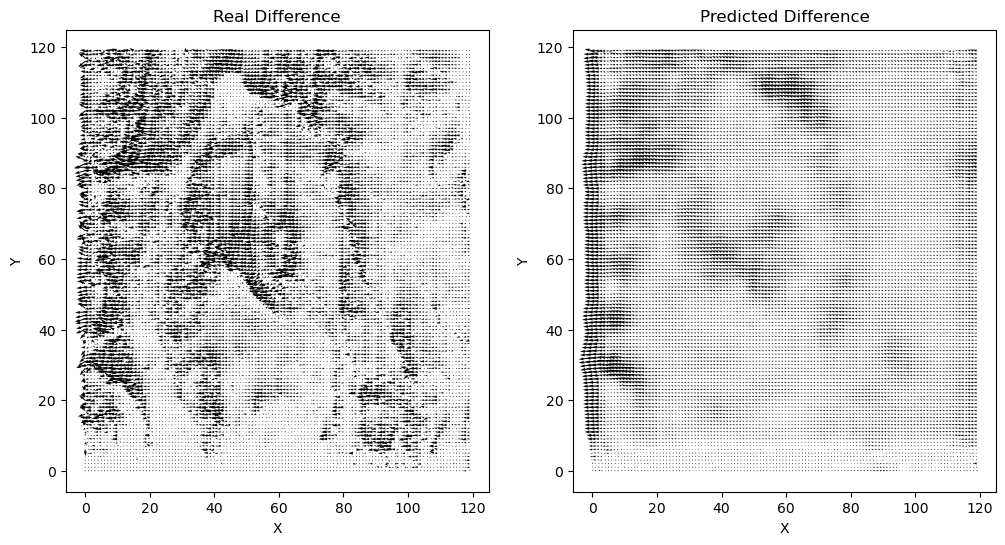

-10.851759


In [29]:
i = 1

U_diff_test = y_test[i, :, :, 0]
V_diff_test = y_test[i, :, :, 1]

U_diff_pred = predictions[i, :, :, 0]
V_diff_pred = predictions[i, :, :, 1]

print("MSE: ", mse)

fig = plt.figure(figsize=(12,6))

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.quiver(U_diff_test, -V_diff_test, scale=300, color="black")
ax1.set_title("Real Difference")
ax1.set_xlabel('X')
ax1.set_ylabel("Y")

ax2.quiver(U_diff_pred, -V_diff_pred, scale=300, color="black")
ax2.set_title("Predicted Difference")
ax2.set_xlabel('X')
ax2.set_ylabel("Y")

plt.show()


